In [20]:
import Pkg
Pkg.activate(@__DIR__)
# Pkg.instantiate()
import MathOptInterface as MOI
import Ipopt
import FiniteDiff
import ForwardDiff as FD
import Convex as cvx
import ECOS
using LinearAlgebra
# using GeometryBasics
using Plots
using Random
using JLD2
using Test
using MeshCat
const mc = MeshCat
using StaticArrays
using Printf
# Pkg.add("FileIO")
# Pkg.add("MeshIO")
using FileIO
using MeshIO

include(joinpath(@__DIR__, "utils", "fmincon.jl"))
include(joinpath(@__DIR__, "utils", "quaternions.jl"))
include(joinpath(@__DIR__, "utils", "quadrotor.jl"))
include(joinpath(@__DIR__, "utils", "util.jl"))

Random.seed!(1234)

  Activating environment at `~/Desktop/16745/recitations-2024/16745proj/Project.toml`


MersenneTwister(1234)

In [21]:
function quad_costs(n_lift, m_lift, scenario=:p2pa)
    if scenario == :hover
        q_diag = 10.0 * ones(n_lift)
        q_diag[4:7] .= 1e-6

        r_diag = 1.0e-3 * ones(m_lift)
        r_diag[end] = 1

        qf_diag = copy(q_diag) * 10.0
    elseif scenario == :p2pa
        q_diag = 1.0 * ones(n_lift)
        q_diag[1] = 1e-5
        # q_diag[4:7] .*= 25.0
        # q_diag

        r_diag = 1.0e-3 * ones(m_lift)
        # r_diag = 1.0e-3*ones(m_lift)
        r_diag[end] = 1

        qf_diag = 100 * ones(n_lift)
    else
        q_diag = 1e-1 * ones(n_lift)
        q_diag[1] = 1e-3
        q_diag[4:7] .*= 25.0

        r_diag = 2.0e-3 * ones(m_lift)

        # r_diag = 1.0e-3*ones(m_lift)
        r_diag[end] = 1

        qf_diag = 100 * ones(n_lift)
    end
    return q_diag, r_diag, qf_diag
end

function load_costs(n_load, m_load, scenario=:p2pa)
    if scenario == :hover
        q_diag = 10.0 * ones(n_load) #

        r_diag = 1 * ones(m_load)
        qf_diag = 10.0 * ones(n_load)
    elseif scenario == :p2p
        q_diag = 1.0 * ones(n_load) #

        # q_diag = 0*ones(n_load)
        q_diag[1] = 1.0e-5
        r_diag = 1 * ones(m_load)
        qf_diag = 0.0 * ones(n_load)

        # q_diag = 1000.0*ones(n_load)
        # r_diag = 1*ones(m_load)
        # qf_diag = 1000.0*ones(n_load)
    else
        q_diag = 0.5e-1 * ones(n_load) #

        # q_diag = 0*ones(n_load)
        # q_diag[1] = 1e-3
        r_diag = 1 * ones(m_load)
        qf_diag = 0.0 * ones(n_load)

        # q_diag = 1000.0*ones(n_load)
        # r_diag = 1*ones(m_load)
        # qf_diag = 1000.0*ones(n_load)

    end
    return q_diag, r_diag, qf_diag
end


load_costs (generic function with 2 methods)

In [22]:
function quad_cost(params::NamedTuple, Z::Vector)::Real
    idx, N = params.idx, params.N
    Q, R, Qf = params.q_load, params.r_load, params.qf_load

    #xg should be a stacked vector of goals [x1g;x2g;x3g...]
    xg = params.xg


    #LQR cost 
    J = 0
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]]

        J += 0.5 * (xi - xg)' * Q * (xi - xg)
        J += 0.5 * ui' * R * ui

    end

    # dont forget terminal cost 
    J += 0.5 * (Z[idx.x[N]] - xg)' * Q * (Z[idx.x[N]] - xg)

    return J
end

# #To add to params/model:
# n_lift = 13
# m_lift = 6 #5 + 1 for quaternion slack variable 
# n_load = 6
# m_load = NUM_QUAD # num quad /L

quad_cost (generic function with 1 method)

In [23]:
# q_lift, r_lift, qf_lift = quad_costs(n_lift, m_lift, scenario)

# cat([q_lift for _ in 1:n]...; dims=(1,2))
# q_load, r_load, qf_load = load_costs(n_load, m_load, scenario)

function system_cost(params::NamedTuple, Z::Vector)::Real
    # cost function 
    idx, N, xg = params.idx, params.N, params.xg
    Q, R, Qf = params.Q, params.R, params.Qf
    Xref, Uref = params.Xref, params.Uref

    J = 0
    for i = 1:N-1
        J += 0.5 * (Z[idx.x[i]] - Xref[i])' * Q * (Z[idx.x[i]] - Xref[i]) +
             0.5 * (Z[idx.u[i]] - Uref[i])' * (R) * (Z[idx.u[i]] - Uref[i]) #TODO 
    end
    J += 0.5 * (Z[idx.x[N]] - Xref[N])' * Qf * (Z[idx.x[N]] - Xref[N])
    return J
end

function dynamics_constraints(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
    model = params.model

    # create c in a ForwardDiff friendly way (check HW0)
    c = zeros(eltype(Z), idx.nc)

    for i = 1:N-1
        #3
        xk = Z[idx.x[i]]
        uk = Z[idx.u[i]]
        c[idx.c[i]] = Z[idx.x[i+1]] - rk4(model, combined_system_dynamics, xk, uk, dt)
    end

    return c
end

function quaternion_constraints(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
    model = params.model

    # create c -1in a ForwardDiff friendly way (check HW0)
    # c = Vector{eltype    c = zeros(eltype(Z), 1)
    c = zeros(eltype(Z), 1)
    for i = 1:N-1
        x = Z[idx.x[i]]
        u = Z[idx.u[i]]
        for k = 1:NUM_QUAD
            quat = x[13*(k-1)+4:13*(k-1)+7]
            s = u[6*NUM_QUAD]
            push!(c, norm(s * quat, 2)^2 - 1)
        end
    end
    return c
end

function equal_tension_cable_constraint(params::NamedTuple, Z::Vector)::Vector
    idx, N = params.idx, params.N
    m_lift = params.m_lift
    NUM_QUAD = params.NUM_QUAD
    M1 = params.M1
    c = zeros(eltype(Z), 1)
    for i = 1:N-1
        ui = Z[idx.u[i]]
        s_inds = m_lift:m_lift:m_lift*NUM_QUAD
        ui_load = ui[(1:NUM_QUAD).+m_lift*NUM_QUAD]
        if (i in M1)
            for i = 1:NUM_QUAD-1
                push!(c, ui[s_inds[i]] - ui_load[i])
            end
            push!(c, 0) # push an extra value
        else
            for i = 1:NUM_QUAD
                push!(c, ui[s_inds[i]] - ui_load[i])
            end
        end
    end
    return c
end

function rope_length_constraint(params::NamedTuple, Z::Vector)::Vector
    idx, N = params.idx, params.N
    dcable = params.dcable
    M1 = params.M1
    c = zeros(eltype(Z), 1)
    for i = 1:N
        xi = Z[idx.x[i]]
        r_load = xi[(1:3).+n_lift*NUM_QUAD]
        xi_quads = [xi[(quad-1)*n_lift+1:n_lift*quad] for quad = 1:NUM_QUAD]
        if (i in M1)
            for j = 1:NUM_QUAD-1
                push!(c, norm(xi_quads[j][1:3] - r_load)^2 - dcable^2)
            end
            push!(c, 0)
        else
            for j = 1:NUM_QUAD
                push!(c, norm(xi_quads[j][1:3] - r_load)^2 - dcable^2)
            end
        end
    end
    return c
end

function equality_constraints(params::NamedTuple, Z::Vector)::Vector
    N, idx, xic, xg = params.N, params.idx, params.xic, params.xg
    return [Z[idx.x[1]] - xic;
        Z[idx.x[N][(1:3).+13*params.NUM_QUAD]] - xg[(1:3).+13*params.NUM_QUAD];
        equal_tension_cable_constraint(params, Z);
        dynamics_constraints(params, Z);
        quaternion_constraints(params, Z);
        rope_length_constraint(params, Z)]
end

equality_constraints (generic function with 1 method)

In [24]:
function proximity_constraint(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
    n_lift = params.n_lift
    NUM_QUAD = params.NUM_QUAD
    dquad = params.dquad
    #Assuming obstacle positions is of form [[x1,y1],[x2,y2]]
    # c = Vector{eltype(Z)}()
    c = zeros(eltype(Z), 1)
    for i = 1:N #Each timestep
        xi = Z[idx.x[i]]
        xi_quads = [xi[(quad-1)*n_lift+1:n_lift*quad] for quad = 1:NUM_QUAD]
        for j = 1:NUM_QUAD
            for k = j+1:NUM_QUAD
                constraint_val = (2 * dquad)^2 - norm(xi_quads[j][1:2] - xi_quads[k][1:2])^2
                push!(c, constraint_val)
            end
        end
    end
    return c
end

function obstacle_proximity_constraint(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
    NUM_QUAD = params.NUM_QUAD
    n_lift = params.n_lift
    obstacle_positions = params.obstacles
    dquad, dobs = params.dquad, params.dobs
    #Assuming obstacle positions is of form [[x1,y1],[x2,y2]]
    c = zeros(eltype(Z), 1)
    for i = 1:N #Each timestep
        xi = Z[idx.x[i]]
        xi_quads = [xi[(quad-1)*n_lift+1:n_lift*quad] for quad = 1:NUM_QUAD]
        for j = 1:length(obstacle_positions) #each obstacle
            for k = 1:NUM_QUAD
                constraint_val = dquad^2 + dobs^2 - norm(xi_quads[k][1:2] - obstacle_positions[j])^2
                push!(c, constraint_val)
            end
        end
    end
    return c
end

function load_proximity_constraint(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
    NUM_QUAD = params.NUM_QUAD
    n_lift = params.n_lift
    obstacle_positions = params.obstacles
    dload, dobs = params.dload, params.dobs
    #Assuming obstacle positions is of form [[x1,y1],[x2,y2]]
    c = zeros(eltype(Z), 1)
    for i = 1:N #Each timestep
        xi = Z[idx.x[i]]
        xi_load = xi[1:2 .+ n_lift*NUM_QUAD]
        for j = 1:length(obstacle_positions) #each obstacle
            constraint_val = dload^2 + dobs^2 - norm(xi_load - obstacle_positions[j])^2
            push!(c, constraint_val)
        end
    end
    return c
end

function positive_cable_tension(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
    m_lift = params.m_lift
    NUM_QUAD = params.NUM_QUAD
    M1 = params.M1
    c = zeros(eltype(Z), 1)
    for i = 1:N-1 #Each timestep
        ui = Z[idx.u[i]]
        ui_load = ui[(1:NUM_QUAD).+m_lift*NUM_QUAD]
        if (i in M1)
            for j = 1:length(ui_load)-1
                push!(c, -ui_load[j])
            end
            push!(c, 0)
        else
            for j = 1:length(ui_load)
                push!(c, -ui_load[j])
            end
        end
    end
    return c
end

function relaxed_cable_length(params::NamedTuple, Z::Vector)::Vector
    idx, N = params.idx, params.N
    dcable = params.dcable
    c = zeros(eltype(Z), 1)
    for i = 1:N
        if (i in M1)
            xi = Z[idx.x[i]]
            r_load = xi[(1:3).+n_lift*NUM_QUAD]
            xi_quads = [xi[(quad-1)*n_lift+1:n_lift*quad] for quad = 1:NUM_QUAD]
            j = NUM_QUAD - 1
            push!(c, norm(xi_quads[j][1:3] - r_load)^2 - dcable^2)
        else
            push!(c, 0)
        end
    end
    return c
end

function inequality_constraints(params::NamedTuple, Z)
    return [proximity_constraint(params, Z);
        # obstacle_proximity_constraint(params, Z);
        # load_proximity_constraint(params, Z);
        positive_cable_tension(params, Z)
        relaxed_cable_length(params, Z)]
end

inequality_constraints (generic function with 1 method)

In [25]:
function states_from_center(NUM_QUAD, load_pos, r=1.55)
    x = [zeros(13) for i = 1:NUM_QUAD+1]
    q10 = [0.99115, 4.90375e-16, 0.132909, -9.56456e-17]
    for i = 1:NUM_QUAD
        x[i] = [r * cos((i * 2 * pi) / NUM_QUAD); r * sin((i * 2 * pi) / NUM_QUAD); 1.55; q10; zeros(13 - 7)] + load_pos
    end
    #Add Load State
    x[end] = [load_pos[1:3]; zeros(3)]
    return x
end


function reference_trajectory(N, xic, xg)
    return collect(range(vcat(xic...), vcat(xg...), length=N))
end

# xic = states_from_center(NUM_QUAD, [-1.5; -1.5; 1.5; zeros(13-3)])
# xg = states_from_center(NUM_QUAD, [1.5; 1.5; 1.5; zeros(13-3)])

# x = reference_trajectory(4, xic, xg)
# println(size(x[1]))

reference_trajectory (generic function with 1 method)

In [55]:
#--------PLACEHOLDER
tf = 10
dt = 1
t_vec = 0:dt:tf
N = length(t_vec)
#-----------------
# problem size 
L = num_lift = NUM_QUAD = 5
nx = 13 * L + 6
nu = 6 * L + L # 5 true controls + 'slack' variable to normalize quat

# create indexing utilities 
idx = create_idx(nx, nu, N)

# index sets 
M1 = vcat([(i) for i = 3:6]...)
J1 = [3, 6]

# dynamics parameters 
model = (lift=quad_params, load=load_params)

#Initial Load and Goal Load
xic_load = [-1.5; -1.5; 0]
xg_load = [1.5; 1.5; 0]

# initial and goal states 
xic = states_from_center(NUM_QUAD, [xic_load; zeros(13 - 3)])
xg = states_from_center(NUM_QUAD, [xg_load; zeros(13 - 3)])

# reference trajectory 
Xref = reference_trajectory(N, xic, xg)
Ucomputed = [1.1815214665742435, 1.1725285168546185, 1.1810130817750433, 1.1815661878894543, -1.0818999327708148, 0.9372432701724972, 1.1815214665742435, 1.1725285168546185, 1.1810130817750433, 1.1815661878894543, -1.0818999327708148, 0.9372432701724972, 1.1267652387723301, 1.127792603322372, 1.1362356567487002, 1.1348861909934034, -0.7771550319298528, 0.983672924337902, 1.1154451185948475, 1.1066755419631378, 1.1177221887457782, 1.1205630997013842, 1.7606344056040273, 1.1966421214072844, 2.7694964161575175, 2.765875797818896, 2.771934187177199, 2.7679922750111383, 6.716992875130551, 0.9878653448440189, 2.5718083666139555, 1.3040877537381708, 1.5744141754456817, 2.4580945268468035, 2.4580945268468035]
Uref = [Ucomputed for i = 1:N-1]
n_lift = 13
m_lift = 6 #5 + 1 for quaternion slack variable 
n_load = 6
m_load = NUM_QUAD
# LQR cost function (tracking Xref, Uref)
q_lift, r_lift, qf_lift = quad_costs(n_lift, m_lift)
q_load, r_load, qf_load = load_costs(n_load, m_load)
Q = diagm(vcat([q_lift for _ in 1:NUM_QUAD]..., q_load))
R = diagm(vcat([r_lift for _ in 1:NUM_QUAD]..., r_load))
Qf = diagm(vcat([qf_lift for _ in 1:NUM_QUAD]..., qf_load))

# put everything useful in params 
params = (
    model=model,
    nx=nx,
    nu=nu,
    tf=tf,
    dt=dt,
    t_vec=t_vec,
    N=N,
    M1=M1,
    J1=J1,
    xic=vcat(xic...),
    xg=vcat(xg...),
    idx=idx,
    Q=Q, R=R, Qf=Qf,
    Xref=Xref,
    Uref=Uref,
    NUM_QUAD=NUM_QUAD,
    n_lift=n_lift,
    m_lift=m_lift, #5 + 1 for quaternion slack variable 
    n_load=n_load,
    m_load=NUM_QUAD, # num quad /L    
    obstacles=[], #Set THESE
    dcable=1.55,
    dload=1.55,
    dquad=0.5,
    dobs=1,
)





# TODO: primal bounds
x_l = -Inf * ones(idx.nz) # update this 
x_u = Inf * ones(idx.nz) # update this 
umax = 5 * ones(4)
rmin = [-Inf -Inf 1.55]
rmax = [Inf Inf 5]
for i = 1:N-1
    #Control Bounds
    u_inds = [(1:4) .+ i for i in (0:m_lift:m_lift*NUM_QUAD-1)]
    for u_index = u_inds
        x_l[idx.u[i][u_index]] .= 0
        x_u[idx.u[i][u_index]] = umax
    end
end

for i = 1:N
    #Position Bounds
    r_inds = [(1:3) .+ i for i in (0:params.n_lift:params.n_lift*NUM_QUAD)]
    for x_idx = r_inds
        x_l[idx.x[i][x_idx]] = rmin
        x_u[idx.x[i][x_idx]] = rmax
    end
end


# TODO: inequality constraint bounds
c_l = -Inf * ones(120) # update this 
c_u = zeros(120) # update this 

# TODO: initialize z0 with the reference Xref, Uref 
z0 = zeros(idx.nz) # update this
for i = 1:N
    z0[idx.x[i]] = Xref[i]
end
for i = 1:N-1
    z0[idx.u[i]] = Uref[i]
end
# adding a little noise to the initial guess is a good idea 
# z0 = z0 + (1e-6) * randn(idx.nz)

diff_type = :auto

# @show size(xic)
# equal_tension_cable_constraint(params, z0)
# @show size(inequality_constraints(params, z0))
# @show size(c_l)
# @show size(c_u)
@show size(inequality_constraints(params, z0))
Z = fmincon(system_cost, equality_constraints, inequality_constraints,
    x_l, x_u, c_l, c_u, z0, params, diff_type;
    tol=1e-6, c_tol=1e-6, max_iters=200, verbose=true)




---------checking dimensions of everything----------


AssertionError: AssertionError: length(c_l) == length(c_u) == n_ineq

In [42]:
# # pull the X and U solutions out of Z 
X = [Z[idx.x[i]] for i = 1:N]
U = [Z[idx.u[i]] for i = 1:(N-1)]

10-element Vector{Vector{Float64}}:
 [0.00011636375210559164, 0.000695050724203098, 7.580415997979488e-5, 0.0008484077631121178, 2.383852060914816, 59.69650755808678, 2.267548635879947e-5, 0.00046261579004958943, 2.9878633864101843e-5, 0.0013031444523253887  …  55.402961440081114, 2.0184751697548524, 2.137439840669302, 2.014641290500379, 2.078353682524205, 4.402341831692315, 0.999976990720436, 59.69650771303648, 55.40296185397051, 0.9999974886041876]
 [0.09804839492096501, 0.11247884951745066, 0.09818659969143566, 0.1171185035116613, 112.58884992543484, 10.578295254896023, 0.1096023879715606, 0.12481390284497176, 0.10957271001544913, 0.11573124422266874  …  8.381496813356351, 2.4426100754223974, 2.268566246929477, 2.4941812489607713, 2.376546278725259, -101.12021261284602, 1.4465708718032835, 10.578293873172328, 8.3814955260087, 1.4465696704049025]
 [0.2779373058113832, 0.2520637106829356, 0.28292324910917466, 0.25063444388867395, -43.76728180880743, 6.365387011730243, 0.33777964388519

In [43]:
@show X[1]

X[1] = [-2.274553816230945, -0.1571585047255759, 1.5526666738698842, 0.9911696842566372, 1.1260660225495139e-5, 0.13262512035437393, 4.191123840932334e-5, 0.00017158252935755953, 0.00011268710048346237, 0.00024234191417664102, -0.002110792193521518, 0.0006432143956167135, -0.006975132347593648, -2.2745761166655867, -2.8428415837673104, 1.5526084795777406, 0.9911243277037703, 7.381889709005968e-5, 0.1330473223447107, 3.736725311913856e-5, 0.00010245310753376511, -6.350348490467343e-5, 0.00022397923790075418, 0.003748613360922034, 0.0006011908630692047, -0.004918061200472759, 0.04959059969303129, -1.4999952242858234, 1.5520311891997847, 0.9911717039657955, 6.551497728487677e-5, 0.13291183562988784, 7.381090708046638e-5, -6.252026811452155e-6, -8.230393701975084e-7, -2.45833356618003e-7, 1.0872795846965227e-5, 1.5188615477422735e-5, 2.689995889509702e-5, -1.500459301066744, -1.500008615414495, 1.5500007944588026, -0.0002601025732533444, -5.3313120491264945e-5, -0.0005271438641364125]


45-element Vector{Float64}:
 -2.274553816230945
 -0.1571585047255759
  1.5526666738698842
  0.9911696842566372
  1.1260660225495139e-5
  0.13262512035437393
  4.191123840932334e-5
  0.00017158252935755953
  0.00011268710048346237
  0.00024234191417664102
  ⋮
  1.0872795846965227e-5
  1.5188615477422735e-5
  2.689995889509702e-5
 -1.500459301066744
 -1.500008615414495
  1.5500007944588026
 -0.0002601025732533444
 -5.3313120491264945e-5
 -0.0005271438641364125

In [44]:
norm([0.99115, 4.90375e-16, 0.132909, -9.56456e-17])
using Random

# Get the current seed
seed_value = Random.seed()

println("Current seed: $seed_value")


UndefVarError: UndefVarError: seed not defined

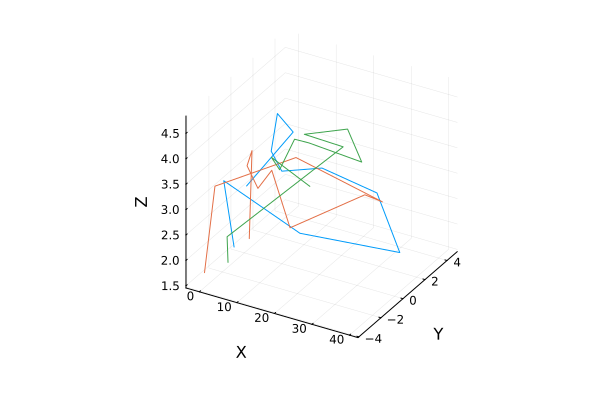

In [45]:
using Plots

function plot_positions(X::Vector, N::Int, NUM_QUAD::Int)
    positions = [[X[i][(quad-1)*13+1:(quad-1)*13+3] for i in 1:N] for quad in 1:NUM_QUAD]
    x_vals = hcat([[pos[1] for pos in quad_positions] for quad_positions in positions]...)
    y_vals = hcat([[pos[2] for pos in quad_positions] for quad_positions in positions]...)
    z_vals = hcat([[pos[3] for pos in quad_positions] for quad_positions in positions]...)
    plot(x_vals, y_vals, z_vals, xlabel="X", ylabel="Y", zlabel="Z", legend=false)
end

# Assuming Z, N, and NUM_QUAD are defined
plot_positions(X, N, NUM_QUAD)


In [46]:
@show Z[idx.x[1]][1:3]
@show Z[idx.x[end]][1:3]


(Z[idx.x[1]])[1:3] = [-2.274553816230945, -0.1571585047255759, 1.5526666738698842]
(Z[idx.x[end]])[1:3] = [-1.8137999305816923, 0.8222583247447823, 2.5806964160078625]


3-element Vector{Float64}:
 -1.8137999305816923
  0.8222583247447823
  2.5806964160078625

In [54]:
let
    vis = mc.Visualizer()
    Point=mc.Point
    function cable_transform(y,z)
        v1 = [0,0,1]
        v2 = y[1:3,1] - z[1:3,1]
        normalize!(v2)
        ax = cross(v1,v2)
        ang = acos(v1'v2)
        R = AngleAxis(ang,ax...)
        compose(Translation(z),LinearMap(R))
    end
    
    function plot_cylinder(vis,c1,c2,radius,mat,name="")
        geom = mc.Cylinder(Point(c1),Point(c2),convert(Float32,radius))
        setobject!(vis["cyl"][name],geom,MeshPhongMaterial(color=RGBA(1, 0, 0, 1.0)))
    end
    
    function addcylinders!(vis,cylinders,height=1.5)
        for (i,cyl) in enumerate(cylinders)
            plot_cylinder(vis,[cyl[1],cyl[2],0],[cyl[1],cyl[2],height],cyl[3],MeshPhongMaterial(color=RGBA(0, 0, 1, 1.0)),"cyl_$i")
        end
    end
    
    
    function visualize_batch(vis,Z,idx,obs=true,num_lift=3)
    
        # camera angle
        # settransform!(vis["/Cameras/default"], compose(Translation(5., -3, 3.),LinearMap(RotX(pi/25)*RotZ(-pi/2))))
    
        if obs
            _cyl = door_obstacles()
            addcylinders!(vis, _cyl, 2.1)
        end
        # @show Z[idx.x[1][1:3]]
        # @show size(Z[idx.x[1]])
        # @show Z[idx.x[1][(num_lift*13) .+ (1:3)]]
        # @show (num_lift*13) .+ (1:3)
        # @show num_lift
        # num_lift * 13 .+ 1:3 = 53:52
        # num_lift = 4
        d = d = norm(Z[idx.x[1]][1:3] - Z[idx.x[1]][num_lift*13 .+ (1:3)])
    
    
        # intialize system
        # obj=(joinpath(@__DIR__, "quadrotor.obj"))
    
        quad_scaling = 1
        # robot_obj = FileIO.load(obj)
        # @show robot_obj
        # robot_obj.vertices .= robot_obj.vertices .* quad_scaling
        robot_obj=mc.MeshFileGeometry(joinpath(@__DIR__, "quadrotor.obj"))
        for i = 1:num_lift
            setobject!(vis["lift$i"],robot_obj,MeshPhongMaterial(color=RGBA(0, 0, 0, 1.0)))
            cable = mc.Cylinder(Point(0,0.0,0.0),Point(0,0,d),0.01)
            setobject!(vis["cable"]["$i"],cable,MeshPhongMaterial(color=RGBA(1, 0, 0, 1.0)))
        end
        setobject!(vis["load"],mc.HyperSphere(Point(0.0, 0.0, 0.0), 0.2) ,MeshPhongMaterial(color=RGBA(0, 1, 0, 1.0)))
    
        anim = MeshCat.Animation(convert(Int,floor(1.0/0.1))) #0.1 is our dt
        for k = 1:idx.N
            MeshCat.atframe(anim,k) do 
                # cables
                x_load = Z[idx.x[k]][num_lift*13 .+ (1:3)]
                for i = 1:num_lift
                    x_lift = Z[idx.x[k]][(i-1)*13 .+ (1:3)]
                    q_lift = Z[idx.x[k]][((i-1)*13 + 3) .+ (1:4)]
                    println(x_lift)
                    println(x_load)
                    settransform!(vis["cable"]["$i"], cable_transform(x_lift,x_load))
                    settransform!(vis["lift$i"], compose(Translation(x_lift...),LinearMap(quad_scaling * Quat(q_lift...))))
                end
                settransform!(vis["load"], Translation(x_load...))
            end
        end
        MeshCat.setanimation!(vis,anim)
    end
    visualize_batch(vis,Z,idx,false,4)
    mc.render(vis)
end

┌ Info: Listening on: 127.0.0.1:8733, thread id: 1
└ @ HTTP.Servers /Users/harshul/.julia/packages/HTTP/vnQzp/src/Servers.jl:382
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8733
└ @ MeshCat /Users/harshul/.julia/packages/MeshCat/QXID5/src/visualizer.jl:64


[-2.274553816230945, -0.1571585047255759, 1.5526666738698842]
[-1.500459301066744, -1.500008615414495, 1.5500007944588026]
[-2.2745761166655867, -2.8428415837673104, 1.5526084795777406]
[-1.500459301066744, -1.500008615414495, 1.5500007944588026]
[0.04959059969303129, -1.4999952242858234, 1.5520311891997847]
[-1.500459301066744, -1.500008615414495, 1.5500007944588026]
[-1.0771379972783637, -1.5018797918472553, 3.135404499338552]
[-1.4738047567569659, -1.6872249226354226, 1.5944551772304199]
[-2.0872647813919745, -1.9571672734626888, 3.0929028253249022]
[-1.4738047567569659, -1.6872249226354226, 1.5944551772304199]
[-0.0018285881759126932, -1.564960370205338, 2.068010850660676]
[-1.4738047567569659, -1.6872249226354226, 1.5944551772304199]
[26.044907101378037, -3.8276993872186806, 3.116642983366881]
[24.688490927811834, -4.008566917670788, 3.954564690686252]
[23.15005670799122, -3.199022702604783, 4.4274795613261535]
[24.688490927811834, -4.008566917670788, 3.954564690686252]
[27.616085

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("lift3" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x68, 0x63, 0x61, 0x74, 0x2f, 0x6c, 0x69, 0x66, 0x74, 0x33], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "load" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x6c, 0x6f, 0x61, 0x64], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "lift2" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x68, 0x63, 0x61, 0x74, 0x2f, 0x6c, 0x69, 0x66, 0x74, 0x32], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "cable" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("1" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x61, 0x74, 0x2f, 0x63, 0x61, 0x62, 0x6c, 0x65, 0x2f, 0x31], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "2" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x61, 0x74, 0x2f, 0x63, 0x61, 0x62, 0x6c, 0x65, 0x2f, 0x32], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "3" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x61, 0x74, 0x2f, 0x63, 0x61, 0x62, 0x6c, 0x65, 0x2f, 0x33], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "lift1" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x68, 0x63, 0x61, 0x74, 0x2f, 0x6c, 0x69, 0x66, 0x74, 0x31], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8733, HTTP.Servers.Server{HTTP.Servers.Listener{Nothing, Sockets.TCPServer}}(HTTP.Servers.Listener{Nothing, Sockets.TCPServer}(Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 8733), "127.0.0.1", "8733", nothing, Sockets.TCPServer(RawFD(59) active)), nothing, Set{HTTP.Connections.Connection}(), Task (runnable) @0x000000017a8ccef0, ReentrantLock(nothing, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), 0))))

In [48]:

@show norm(X[1] - vcat(xic...))
@show norm(X[8] - vcat(xg...))

norm(X[1] - vcat(xic...)) = 1.5500369424280027
norm(X[8] - vcat(xg...)) = 12.226689795053998


12.226689795053998

In [49]:
# @show Z[idx.u[end]]
newUinitial = [Z[idx.u[i]] for i = 1:N-1]
# Z[idx.u[end]] = [1.1815214665742435, 1.1725285168546185, 1.1810130817750433, 1.1815661878894543, -1.0818999327708148, 0.9372432701724972, 1.1267652387723301, 1.127792603322372, 1.1362356567487002, 1.1348861909934034, -0.7771550319298528, 0.983672924337902, 1.1154451185948475, 1.1066755419631378, 1.1177221887457782, 1.1205630997013842, 1.7606344056040273, 1.1966421214072844, 2.7694964161575175, 2.765875797818896, 2.771934187177199, 2.7679922750111383, 6.716992875130551, 0.9878653448440189, 2.5718083666139555, 1.3040877537381708, 1.5744141754456817, 2.4580945268468035]

10-element Vector{Vector{Float64}}:
 [0.00011636375210559164, 0.000695050724203098, 7.580415997979488e-5, 0.0008484077631121178, 2.383852060914816, 59.69650755808678, 2.267548635879947e-5, 0.00046261579004958943, 2.9878633864101843e-5, 0.0013031444523253887  …  55.402961440081114, 2.0184751697548524, 2.137439840669302, 2.014641290500379, 2.078353682524205, 4.402341831692315, 0.999976990720436, 59.69650771303648, 55.40296185397051, 0.9999974886041876]
 [0.09804839492096501, 0.11247884951745066, 0.09818659969143566, 0.1171185035116613, 112.58884992543484, 10.578295254896023, 0.1096023879715606, 0.12481390284497176, 0.10957271001544913, 0.11573124422266874  …  8.381496813356351, 2.4426100754223974, 2.268566246929477, 2.4941812489607713, 2.376546278725259, -101.12021261284602, 1.4465708718032835, 10.578293873172328, 8.3814955260087, 1.4465696704049025]
 [0.2779373058113832, 0.2520637106829356, 0.28292324910917466, 0.25063444388867395, -43.76728180880743, 6.365387011730243, 0.33777964388519

In [50]:
@show xg

xg = [[0.7250000000000003, 2.8423393758658797, 1.55, 0.99115, 4.90375e-16, 0.132909, -9.56456e-17, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.7249999999999993, 0.1576606241341203, 1.55, 0.99115, 4.90375e-16, 0.132909, -9.56456e-17, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [3.05, 1.4999999999999996, 1.55, 0.99115, 4.90375e-16, 0.132909, -9.56456e-17, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.5, 1.5, 0.0, 0.0, 0.0, 0.0]]


4-element Vector{Vector{Float64}}:
 [0.7250000000000003, 2.8423393758658797, 1.55, 0.99115, 4.90375e-16, 0.132909, -9.56456e-17, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.7249999999999993, 0.1576606241341203, 1.55, 0.99115, 4.90375e-16, 0.132909, -9.56456e-17, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [3.05, 1.4999999999999996, 1.55, 0.99115, 4.90375e-16, 0.132909, -9.56456e-17, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [1.5, 1.5, 0.0, 0.0, 0.0, 0.0]

In [51]:
@show x_u


x_u = [Inf, Inf, 5.0, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, 5.0, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, 5.0, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, 5.0, Inf, Inf, Inf, 5.0, 5.0, 5.0, 5.0, Inf, Inf, 5.0, 5.0, 5.0, 5.0, Inf, Inf, 5.0, 5.0, 5.0, 5.0, Inf, Inf, Inf, Inf, Inf, Inf, Inf, 5.0, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, 5.0, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, 5.0, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, 5.0, Inf, Inf, Inf, 5.0, 5.0, 5.0, 5.0, Inf, Inf, 5.0, 5.0, 5.0, 5.0, Inf, Inf, 5.0, 5.0, 5.0, 5.0, Inf, Inf, Inf, Inf, Inf, Inf, Inf, 5.0, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, 5.0, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, 5.0, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, 5.0, Inf, Inf, Inf, 5.0, 5.0, 5.0, 5.0, Inf, Inf, 5.0, 5.0, 5.0, 5.0, Inf, Inf, 5.0, 5.0, 5.0, 5.0, Inf, Inf, Inf, Inf, Inf, Inf

705-element Vector{Float64}:
 Inf
 Inf
  5.0
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
  ⋮
 Inf
 Inf
 Inf
 Inf
 Inf
  5.0
 Inf
 Inf
 Inf